**Results**: Best hyperparameters for Random Forest:
* N = 150 trees
* Better with no class weights (both in acc and F1)
* Entropy criterion produces slightly better results than Gini


In [1]:
import sys
sys.path.append('..')
from myfunctions_dataloader import mydataloader_cv
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [3]:
d = mydataloader_cv()
Fs = 50
root = 'C:/Users/Javi/Documents/GitHub/TFM/'
d.load_data(path=root+'example_processed_data_v5', K=5, max_n_files=20)

 
There are less files than the provided maximum
shhs1-200001 loaded!
shhs1-200002 loaded!
shhs1-200003 loaded!
shhs1-200004 loaded!
shhs1-200005 loaded!
shhs1-200006 loaded!
shhs1-200007 loaded!
shhs1-200008 loaded!
shhs1-200009 loaded!
shhs1-200010 loaded!
shhs1-200011 loaded!
shhs1-200012 loaded!
shhs1-200013 loaded!
shhs1-200014 loaded!
shhs1-200015 loaded!
shhs1-200016 loaded!
shhs1-200017 loaded!
shhs1-200018 loaded!
shhs1-200019 loaded!
shhs1-200020 loaded!
Validation subjects in fold 0 [ 0  1 15 17]
Validation subjects in fold 1 [ 3  5  8 11]
Validation subjects in fold 2 [ 2 13 16 18]
Validation subjects in fold 3 [ 4  9 12 19]
Validation subjects in fold 4 [ 6  7 10 14]


In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_cv_train = [ [] for k in range(d.K)]
X_cv_valid = [ [] for k in range(d.K)]
for k in range(d.K):
    X_cv_train[k] = np.concatenate(
        [d.stats_cv_train[k].reshape((d.stats_cv_train[k].shape[0],-1)),
         d.PSD_highres_cv_train[k].reshape((d.PSD_highres_cv_train[k].shape[0],-1)),
         d.AR_coefs_cv_train[k].reshape((d.AR_coefs_cv_train[k].shape[0],-1))],axis=1)
    
    X_cv_valid[k] = np.concatenate(
        [d.stats_cv_valid[k].reshape((d.stats_cv_valid[k].shape[0],-1)),
         d.PSD_highres_cv_valid[k].reshape((d.PSD_highres_cv_valid[k].shape[0],-1)),
         d.AR_coefs_cv_valid[k].reshape((d.AR_coefs_cv_valid[k].shape[0],-1))], axis=1)
    
    # use the standard scaler for proper behaviour
    X_cv_train[k] = scaler.fit_transform(X_cv_train[k])
    X_cv_valid[k] = scaler.transform(X_cv_valid[k])

In [5]:
X_cv_train[0].shape

(15533, 232)

In [6]:
import seaborn as sb

def plot_mean_cm(cm_list):
    K = len(cm_list)
    full_valid_cm = np.asarray(cm_list)
    sum_valid_cm = np.sum(full_valid_cm, axis=0)
    cm = sum_valid_cm

    counts_per_class = cm.sum(axis=1)  # how much of each class is there (real classes)
    counts_per_class[counts_per_class == 0] = 1  # to avoid division by zero
    normcm = (cm.T / counts_per_class).T  # normalize by real classes

    labels = ['Wake', 'N1', 'N2', 'N3', 'REM']
    cmap = 'gist_gray'  # 'coolwarm'

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [1, 5]})
    norm_counts_per_class = (counts_per_class / np.sum(counts_per_class)).reshape(-1, 1)
    sb.heatmap(norm_counts_per_class, ax=ax1, annot=True, fmt='.2f', cmap=cmap, xticklabels=[], yticklabels=labels,
               cbar=False, vmin=0, vmax=0.5)
    sb.heatmap(normcm, ax=ax2, annot=True, fmt='.2f', cmap=cmap, xticklabels=labels, linewidths=0.05, cbar=False,
               vmin=0, vmax=1, yticklabels=labels)
    ax1.set_ylabel('Real')
    ax2.set_ylabel('Real')
    ax2.set_xlabel('Predicted')
    ax1.tick_params(axis='both', which='both', length=0)
    ax2.tick_params(axis='both', which='both', length=0)
    ax1.set_title('Relative density of\neach real class')
    plt.show()

# Random Forest

Mean acc 73.6 +- 3.2 %
Mean MacroF1 0.563 +- 0.036 %


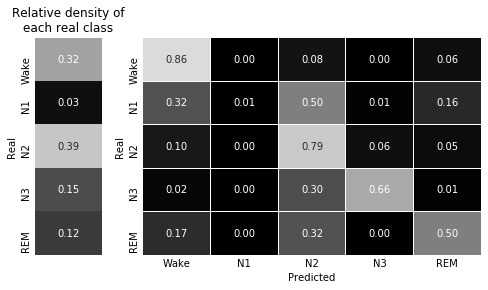

In [7]:
clf = RF(n_estimators=50, n_jobs=-1)

acc = []
f1macro = []
cm = []
for k in range(d.K):
    clf.fit(X_cv_train[k],d.hypnogram_cv_train[k])
    pred = clf.predict(X_cv_valid[k])
    acc.append(accuracy_score(d.hypnogram_cv_valid[k], pred))
    f1macro.append(f1_score(d.hypnogram_cv_valid[k], pred,average='macro'))
    cm.append(confusion_matrix(d.hypnogram_cv_valid[k], pred))   
print('Mean acc %.1f +- %.1f %%' %(100*np.mean(acc),100*np.std(acc)))
print('Mean MacroF1 %.3f +- %.3f %%' %(np.mean(f1macro),np.std(f1macro)))
plot_mean_cm(cm)

In [8]:
print(acc)

[0.7129213483146067, 0.7288741383712024, 0.7917195834391669, 0.7430412371134021, 0.7009739405106608]


Mean acc 73.1 +- 3.1 %
Mean MacroF1 0.550 +- 0.034 %


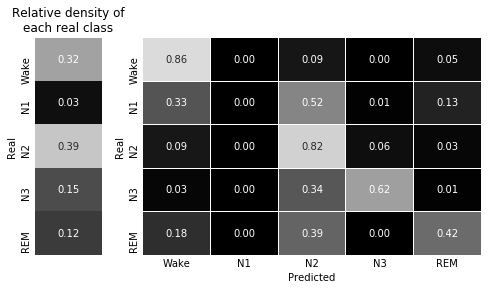

In [11]:
clf = RF(n_estimators=50, n_jobs=-1, class_weight={0:1,1:3,2:1,3:2,4:2})

acc = []
f1macro = []
cm = []
for k in range(d.K):
    clf.fit(X_cv_train[k],d.hypnogram_cv_train[k])
    pred = clf.predict(X_cv_valid[k])
    acc.append(accuracy_score(d.hypnogram_cv_valid[k], pred))
    f1macro.append(f1_score(d.hypnogram_cv_valid[k], pred,average='macro'))
    cm.append(confusion_matrix(d.hypnogram_cv_valid[k], pred))   
print('Mean acc %.1f +- %.1f %%' %(100*np.mean(acc),100*np.std(acc)))
print('Mean MacroF1 %.3f +- %.3f %%' %(np.mean(f1macro),np.std(f1macro)))
plot_mean_cm(cm)

# Grid Search over RF
Let's try the GridSeach function. However, it will mix the subjects probably and that will distort the results. Let's see anyway.

In [16]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': range(100,151,10)} 
clf = GridSearchCV(RF(), parameters, cv=5, n_jobs=-1, scoring='accuracy')
clf.fit(X_cv_train[0], d.hypnogram_cv_train[0])
print(clf.cv_results_['mean_test_score'])
prediction = clf.best_estimator_.predict(X_cv_valid[0])
print('Test accuracy: ',accuracy_score(prediction, d.hypnogram_cv_valid[0]))
print('Test macro F1: ',f1_score(prediction, d.hypnogram_cv_valid[0],average='macro'))

[0.71306706 0.71235948 0.71332487 0.71081386 0.71268106 0.71422613]
Test accuracy:  0.7132022471910112
Test macro F1:  0.5249320867062115


In [17]:
results = pd.DataFrame(clf.cv_results_)
print(results)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      35.480922      0.688295         0.135078        0.005030   
1      38.835146      0.815252         0.147574        0.004427   
2      42.553937      0.585411         0.160039        0.007293   
3      46.036032      0.904275         0.177394        0.004819   
4      49.911973      1.109932         0.183433        0.004215   
5      50.320483      4.399657         0.179906        0.029493   

  param_n_estimators                 params  split0_test_score  \
0                100  {'n_estimators': 100}           0.749920   
1                110  {'n_estimators': 110}           0.748310   
2                120  {'n_estimators': 120}           0.747667   
3                130  {'n_estimators': 130}           0.745735   
4                140  {'n_estimators': 140}           0.747988   
5                150  {'n_estimators': 150}           0.749598   

   split1_test_score  split2_test_score  split3_test_score  split4_

Mean acc 74.0 +- 3.6 %
Mean MacroF1 0.565 +- 0.040 %


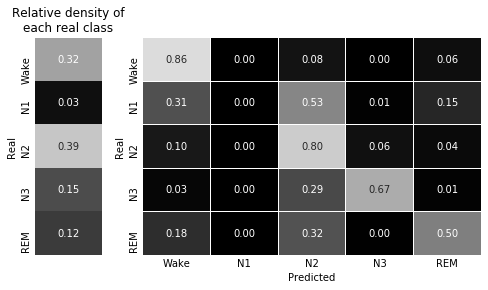

In [18]:
clf = RF(n_estimators=100, n_jobs=-1)

acc = []
f1macro = []
cm = []
for k in range(d.K):
    clf.fit(X_cv_train[k],d.hypnogram_cv_train[k])
    pred = clf.predict(X_cv_valid[k])
    acc.append(accuracy_score(d.hypnogram_cv_valid[k], pred))
    f1macro.append(f1_score(d.hypnogram_cv_valid[k], pred,average='macro'))
    cm.append(confusion_matrix(d.hypnogram_cv_valid[k], pred))   
print('Mean acc %.1f +- %.1f %%' %(100*np.mean(acc),100*np.std(acc)))
print('Mean MacroF1 %.3f +- %.3f %%' %(np.mean(f1macro),np.std(f1macro)))
plot_mean_cm(cm)

Mean acc 74.2 +- 3.8 %
Mean MacroF1 0.567 +- 0.040 %


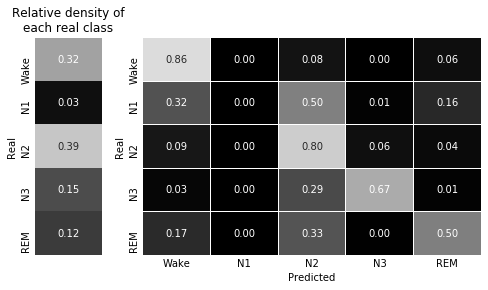

In [19]:
clf = RF(n_estimators=150, n_jobs=-1)

acc = []
f1macro = []
cm = []
for k in range(d.K):
    clf.fit(X_cv_train[k],d.hypnogram_cv_train[k])
    pred = clf.predict(X_cv_valid[k])
    acc.append(accuracy_score(d.hypnogram_cv_valid[k], pred))
    f1macro.append(f1_score(d.hypnogram_cv_valid[k], pred,average='macro'))
    cm.append(confusion_matrix(d.hypnogram_cv_valid[k], pred))   
print('Mean acc %.1f +- %.1f %%' %(100*np.mean(acc),100*np.std(acc)))
print('Mean MacroF1 %.3f +- %.3f %%' %(np.mean(f1macro),np.std(f1macro)))
plot_mean_cm(cm)

## CV with class weights
Macro F1 as target. Best results with no class balance.

In [21]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': [50,100,150], 
              'class_weight': [None, 'balanced',
                              {0:1,1:3,2:1,3:2,4:2},
                              {0:1,1:3,2:1,3:3,4:3}]} 
clf = GridSearchCV(RF(), parameters, cv=5, n_jobs=-1, scoring='f1_macro')
clf.fit(X_cv_train[0], d.hypnogram_cv_train[0])
print(clf.cv_results_['mean_test_score'])
results = pd.DataFrame(clf.cv_results_)
print(results)
prediction = clf.best_estimator_.predict(X_cv_valid[0])
print('Test accuracy: ',accuracy_score(prediction, d.hypnogram_cv_valid[0]))
print('Test macro F1: ',f1_score(prediction, d.hypnogram_cv_valid[0],average='macro'))

[0.54615212 0.54733978 0.54706495 0.53015876 0.53155757 0.53251004
 0.53040671 0.53605489 0.53906722 0.53396961 0.53163975 0.53539046]
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       19.052116      1.837086         0.135442        0.033972   
1       40.289789      1.461038         0.151889        0.006528   
2       56.273189      1.067143         0.217656        0.014103   
3       17.511952      0.451927         0.075040        0.009744   
4       35.515103      0.606211         0.147603        0.010992   
5       53.281732      0.739088         0.235221        0.031707   
6       17.484547      0.155672         0.085039        0.008304   
7       37.557942      1.046298         0.139265        0.007553   
8       53.590915      1.746679         0.195335        0.003756   
9       18.125893      0.278003         0.107638        0.025489   
10      35.986139      0.602387         0.155685        0.024588   
11      48.956593      5.436786         0.211880 

## CV with separation method
Gini vs entropy
They produce very similar results, entropy is slightly better.

In [22]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': [50,100,150], 
              'criterion': ['gini','entropy'],
              'min_samples_split':[2,10,50]
             } 
clf = GridSearchCV(RF(), parameters, cv=5, n_jobs=-1, scoring='f1_macro')
clf.fit(X_cv_train[0], d.hypnogram_cv_train[0])
print(clf.cv_results_['mean_test_score'])
results = pd.DataFrame(clf.cv_results_)
print(results)
prediction = clf.best_estimator_.predict(X_cv_valid[0])
print('Test accuracy: ',accuracy_score(prediction, d.hypnogram_cv_valid[0]))
print('Test macro F1: ',f1_score(prediction, d.hypnogram_cv_valid[0],average='macro'))

[0.53802213 0.54398684 0.53943855 0.54533673 0.545315   0.54606667
 0.53803136 0.53962483 0.54132211 0.54496406 0.54905722 0.5455797
 0.54582991 0.54302747 0.54578411 0.53583346 0.53934616 0.54134799]
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       19.695286      0.654156         0.086752        0.013438   
1       39.447306      2.389538         0.135197        0.004239   
2       54.348173      1.187405         0.211961        0.006454   
3       18.558671      0.681685         0.076271        0.012299   
4       35.638296      0.507751         0.132776        0.003212   
5       54.617580      0.789933         0.201784        0.011063   
6       16.727463      0.588305         0.063858        0.003534   
7       33.829518      0.684997         0.130770        0.019305   
8       51.576907      1.583000         0.199752        0.033085   
9       35.724432      0.760230         0.063349        0.003754   
10      70.958328      0.686635         0.119486   

In [29]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': [50,100,150,200,250,300], 
              'criterion': ['gini','entropy']
             } 
clf = GridSearchCV(RF(), parameters, cv=5, n_jobs=-1, scoring='f1_macro')
clf.fit(X_cv_train[0], d.hypnogram_cv_train[0])
print(clf.cv_results_['mean_test_score'])
results = pd.DataFrame(clf.cv_results_)
prediction = clf.best_estimator_.predict(X_cv_valid[0])
print('Test accuracy: ',accuracy_score(prediction, d.hypnogram_cv_valid[0]))
print('Test macro F1: ',f1_score(prediction, d.hypnogram_cv_valid[0],average='macro'))

[0.53780901 0.54679554 0.54805148 0.54621964 0.54680744 0.54587742
 0.54298268 0.54426114 0.54772336 0.54470732 0.54399329 0.54589918]
Test accuracy:  0.7176966292134831
Test macro F1:  0.5330527582551083


In [30]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,35.361403,0.636016,0.143139,0.016655,gini,50,"{'criterion': 'gini', 'n_estimators': 50}",0.574428,0.523544,0.446820,0.555774,0.588479,0.537809,0.050425,12
1,51.503818,8.433681,0.153917,0.007657,gini,100,"{'criterion': 'gini', 'n_estimators': 100}",0.576464,0.532947,0.467574,0.568572,0.588420,0.546796,0.043715,4
2,58.005997,1.367794,0.221936,0.026937,gini,150,"{'criterion': 'gini', 'n_estimators': 150}",0.582066,0.528430,0.464592,0.576851,0.588318,0.548051,0.046815,1
3,75.175189,1.362751,0.288130,0.017533,gini,200,"{'criterion': 'gini', 'n_estimators': 200}",0.575173,0.529803,0.463777,0.575259,0.587086,0.546220,0.045646,5
4,102.047925,16.030476,0.488904,0.186263,gini,250,"{'criterion': 'gini', 'n_estimators': 250}",0.575935,0.529654,0.466780,0.572264,0.589405,0.546807,0.044743,3
5,143.877175,24.453022,0.386402,0.010421,gini,300,"{'criterion': 'gini', 'n_estimators': 300}",0.579727,0.528706,0.459781,0.570607,0.590565,0.545877,0.047879,7
6,36.013217,1.142220,0.062505,0.003078,entropy,50,"{'criterion': 'entropy', 'n_estimators': 50}",0.574702,0.525325,0.470464,0.565073,0.579349,0.542983,0.040957,11
7,69.556897,1.721175,0.118941,0.003053,entropy,100,"{'criterion': 'entropy', 'n_estimators': 100}",0.574442,0.522756,0.474734,0.566052,0.583322,0.544261,0.040517,9
8,104.251239,2.708343,0.173774,0.006433,entropy,150,"{'criterion': 'entropy', 'n_estimators': 150}",0.582247,0.530548,0.468412,0.569946,0.587464,0.547723,0.044386,2
9,139.168172,2.761809,0.229753,0.004053,entropy,200,"{'criterion': 'entropy', 'n_estimators': 200}",0.578818,0.526926,0.472960,0.563542,0.581290,0.544707,0.040793,8


Mean acc 74.2 +- 3.9 %
Mean MacroF1 0.565 +- 0.040 %


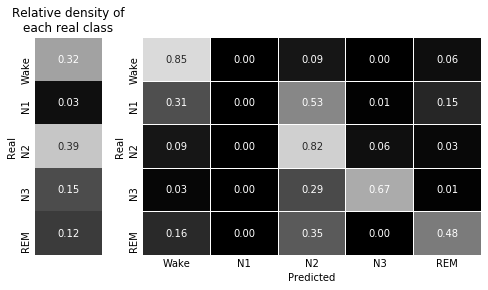

In [25]:
clf = RF(n_estimators=150, n_jobs=-1, criterion='entropy')

acc = []
f1macro = []
cm = []
for k in range(d.K):
    clf.fit(X_cv_train[k],d.hypnogram_cv_train[k])
    pred = clf.predict(X_cv_valid[k])
    acc.append(accuracy_score(d.hypnogram_cv_valid[k], pred))
    f1macro.append(f1_score(d.hypnogram_cv_valid[k], pred,average='macro'))
    cm.append(confusion_matrix(d.hypnogram_cv_valid[k], pred))   
print('Mean acc %.1f +- %.1f %%' %(100*np.mean(acc),100*np.std(acc)))
print('Mean MacroF1 %.3f +- %.3f %%' %(np.mean(f1macro),np.std(f1macro)))
plot_mean_cm(cm)


Mean acc 74.0 +- 3.6 %
Mean MacroF1 0.564 +- 0.040 %


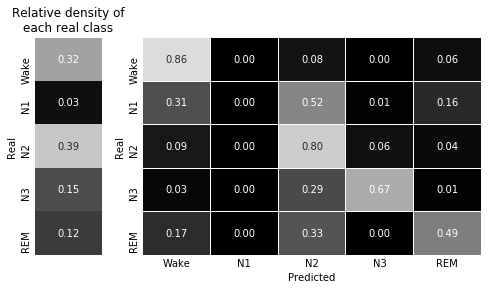

In [26]:
clf = RF(n_estimators=150, n_jobs=-1, criterion='gini')

acc = []
f1macro = []
cm = []
for k in range(d.K):
    clf.fit(X_cv_train[k],d.hypnogram_cv_train[k])
    pred = clf.predict(X_cv_valid[k])
    acc.append(accuracy_score(d.hypnogram_cv_valid[k], pred))
    f1macro.append(f1_score(d.hypnogram_cv_valid[k], pred,average='macro'))
    cm.append(confusion_matrix(d.hypnogram_cv_valid[k], pred))   
print('Mean acc %.1f +- %.1f %%' %(100*np.mean(acc),100*np.std(acc)))
print('Mean MacroF1 %.3f +- %.3f %%' %(np.mean(f1macro),np.std(f1macro)))
plot_mean_cm(cm)
# criterion gini gives 74.2% acc, 56.7% F1 score